<img style="margin: 0 auto;" src="https://desafiolatam.com/assets/home/logo-academia-bla-790873cdf66b0e681dfbe640ace8a602f5330bec301c409744c358330e823ae3.png">

# Desafio 2 Rendimiento escolar

#### Integrantes
* Catalina Cerda
* José González
* Luis Porras

In [22]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import missingno

#Ignorar Avisos
import warnings
warnings.filterwarnings("ignore")

#Libreria funciones auxiliares

# Hito 1: Sesión Presencial 1, Unidad 7
Completar el punto de Preliminares, así como Aspectos computacionales.

### Desafío 2: Rendimiento escolar
#### Enunciado
Lo contactan de una escuela Portuguesa para generar un modelo que identifique aquellos alumnos
que presentan un bajo desempeño académico, medido en el promedio final del año escolar. Para ello
le envían un archivo con registros sociodemográficos y conductuales de los alumnos dos escuelas
para perfilar a los estudiantes.
De manera adicional la psicopedagoga sugiere inspeccionar una batería de preguntas asociadas a
aspectos ambientales del alumno (de famrel a health ) y ver si éstas se pueden abstraer en
categorías latentes.
### Aspectos adicionales a considerar
* La base de datos presenta una serie de anomalías. En la escuela no tienen buenas prácticas sobre cómo ingresar datos, por lo que existen datos perdidos que están registrados bajo tres categorías: nulidade, sem validade, zero. De manera adicional, hay 3 variables numéricas que se registraron como strings, cuya interpretación en pandas devuelve una estructura de datos genérica. Finalmente, la base está con un encoding distinto al normal y los delimitadores son distintos.
<br>
* Para simplficar el análisis y su posterior inclusión en un modelo predictivo, se sugiere recodificar las variables binarias como 0 y 1. Se recomienda seguir en criterio de asignarle 1 a aquellas categorías minoritarias.
<br>
* El procedimiento también debe aplicarse para aquelas variables nominales con más de 2 categorías siguiendo la misma lógica.
<br>
* En la parte de modelación descriptiva, se deben generar modelos saturados por cada una de las notas registradas en G1 , G2 y G3.
<br>
* Para la parte de modelación predictiva, se debe generar un modelo para predecir las notas en G3 .

In [3]:
#cargamos el dataframe y lo asignamos al valor 'df_student'
df_student = pd.read_csv('students.csv', sep='|', encoding='iso-8859-1') #con el argumento sep separamos las celdas de la base de dato
df_student.head()

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,GP,F,nulidade,U,GT3,A,4,4,at_home,...,4,3,"""4""",1,1,"""3""",6,5,6,6
1,1,GP,F,"""17""",U,GT3,T,1,1,at_home,...,5,3,"""3""",1,1,"""3""",4,5,5,6
2,2,GP,F,"""15""",U,LE3,T,1,1,at_home,...,4,3,"""2""",2,3,"""3""",10,zero,8,10
3,3,GP,F,"""15""",U,GT3,T,4,2,health,...,3,2,"""2""",1,1,"""5""",2,15,14,15
4,4,GP,F,sem validade,U,GT3,T,3,3,other,...,4,3,"""2""",1,2,"""5""",4,6,10,10


Primero dropeamos la columna `Unnamed: 0`

In [5]:
df_desafio2 = df_student.drop(columns = 'Unnamed: 0', axis = 1)
df_desafio2.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,nulidade,U,GT3,A,4,4,at_home,teacher,...,4,3,"""4""",1,1,"""3""",6,5,6,6
1,GP,F,"""17""",U,GT3,T,1,1,at_home,other,...,5,3,"""3""",1,1,"""3""",4,5,5,6
2,GP,F,"""15""",U,LE3,T,1,1,at_home,other,...,4,3,"""2""",2,3,"""3""",10,zero,8,10
3,GP,F,"""15""",U,GT3,T,4,2,health,services,...,3,2,"""2""",1,1,"""5""",2,15,14,15
4,GP,F,sem validade,U,GT3,T,3,3,other,other,...,4,3,"""2""",1,2,"""5""",4,6,10,10


Reemplazamos todos los datos mal ingresados (`nulidade`, `sem validade`, `zero`) por `NaN`

In [6]:
df_desafio2 = df_desafio2.replace('nulidade', np.nan)
df_desafio2 = df_desafio2.replace('sem validade', np.nan)
df_desafio2 = df_desafio2.replace('zero',np.nan)
df_desafio2.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,NaN,U,GT3,A,4,4,at_home,teacher,...,4,3,"""4""",1,1,"""3""",6,5,6,6
1,GP,F,"""17""",U,GT3,T,1,1,at_home,other,...,5,3,"""3""",1,1,"""3""",4,5,5,6
2,GP,F,"""15""",U,LE3,T,1,1,at_home,other,...,4,3,"""2""",2,3,"""3""",10,NaN,8,10
3,GP,F,"""15""",U,GT3,T,4,2,health,services,...,3,2,"""2""",1,1,"""5""",2,15,14,15
4,GP,F,NaN,U,GT3,T,3,3,other,other,...,4,3,"""2""",1,2,"""5""",4,6,10,10


Reemplazamos los valores `string-numericos` a `Float`

In [8]:
df_desafio2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null object
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null object
Fedu          390 non-null object
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc       

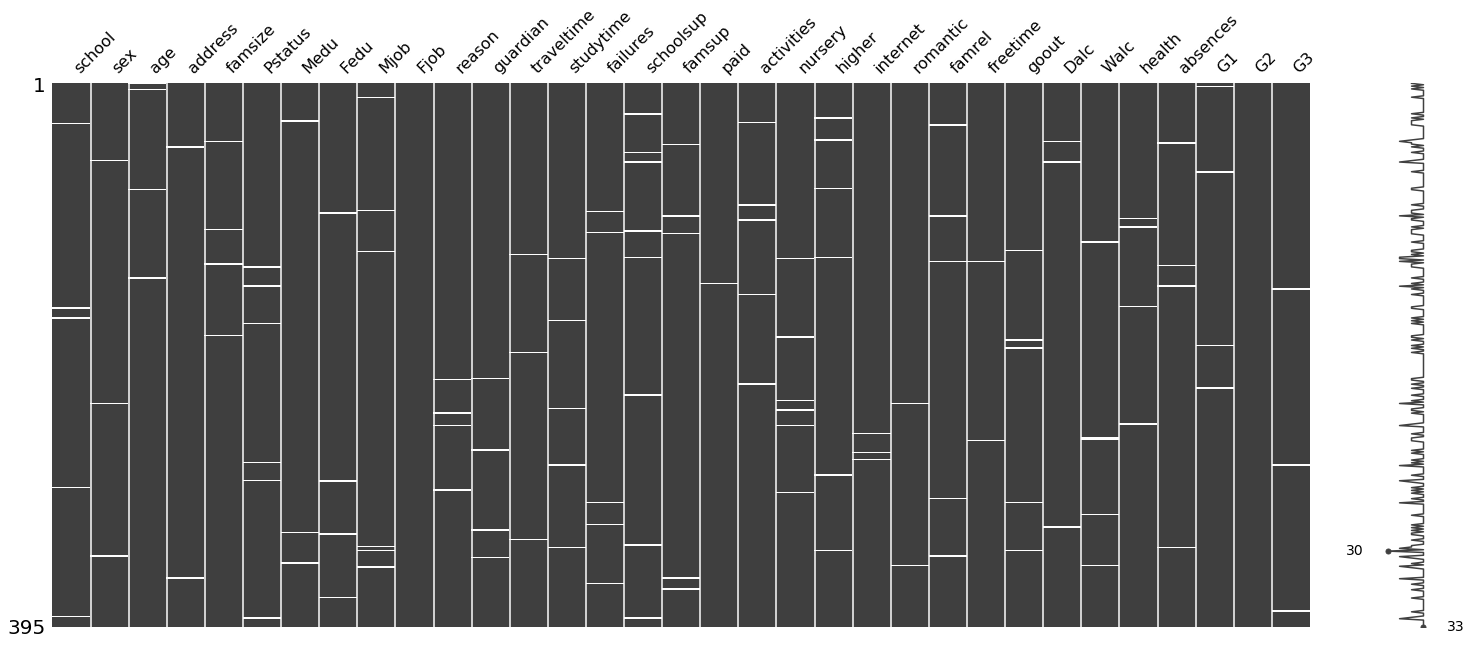

In [9]:
missingno.matrix(df_desafio2)

In [10]:
df_desafio2_dropped = df_desafio2.dropna()

In [11]:
print(f"El porcentaje de datos perdidos si eliminamos todos los N/A es de: {round(len(df_desafio2_dropped)/len(df_desafio2)*100, 2)}%")

El porcentaje de datos perdidos si eliminamos todos los N/A es de: 71.9%


Recodificando columna `age` de `String` a `Float`:

In [12]:
df_desafio2['age'].value_counts()

"16"    101
"17"     98
"15"     82
"18"     81
"19"     24
"20"      3
"22"      1
"21"      1
Name: age, dtype: int64

In [13]:
df_desafio2['age'] = df_desafio2['age'].str.replace('\"','')
df_desafio2['age'].value_counts()

16    101
17     98
15     82
18     81
19     24
20      3
22      1
21      1
Name: age, dtype: int64

In [14]:
df_desafio2['age'] = df_desafio2['age'].astype('float')

Recodificando columna `absences` de `String` a `Float`:

In [15]:
df_desafio2['absences'].value_counts(dropna=False)

0      113
2       64
4       53
6       31
8       22
10      17
14      12
12      11
3        8
7        7
16       7
18       5
5        5
20       4
NaN      4
11       3
22       3
1        3
15       3
13       3
9        3
40       1
23       1
30       1
17       1
38       1
21       1
24       1
28       1
19       1
54       1
26       1
25       1
56       1
75       1
Name: absences, dtype: int64

In [16]:
df_desafio2['absences'] = df_desafio2['absences'].astype('float')
df_desafio2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null object
Fedu          390 non-null object
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc      

Recodificando columna `G1` de `String` a `Float`:

In [17]:
df_desafio2['G1'].value_counts(dropna=False)

10     50
8      41
11     38
7      36
12     35
13     33
9      31
14     30
15     24
6      23
16     22
18      8
17      8
5       7
NaN     4
19      3
3       1
4       1
Name: G1, dtype: int64

In [18]:
df_desafio2['G1'] = df_desafio2['G1'].astype('float')
df_desafio2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null object
Fedu          390 non-null object
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc      

Recodificando columna `G2` de `Int` a `Float`:

In [19]:
df_desafio2['G2'] = df_desafio2['G2'].astype('float')
df_desafio2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null object
Fedu          390 non-null object
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc      

Recodificando columna `G3` de `String` a `Float`:

In [20]:
df_desafio2['G3'] = df_desafio2['G3'].astype('float')
df_desafio2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null object
Fedu          390 non-null object
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc      

* Para simplficar el análisis y su posterior inclusión en un modelo predictivo, se sugiere recodificarlas variables binarias como 0 y 1. Se recomienda seguir en criterio de asignarle 1 a aquellas categorías minoritarias.

Reemplazamos las variables  binarias ('school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic')

# agregar la función 

* En la parte de modelación descriptiva, se deben generar modelos saturados por cada una de las notas registradas en `G1` , `G2` y `G3`.

# Hito 3

In [23]:
#statsmodels para modelación descriptiva

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [24]:
#Modelo Saturado

df_msaturado = pd.DataFrame(df_desafio2)
df_msaturado = pd.concat([x_train,df_msaturado])
df_msaturado['G3']=y_train
model = ols('G1 ~ G2 + G1', data=df_msaturado).fit()
model.summary()

NameError: name 'x_train' is not defined